In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
train_df = pd.read_csv('data/train.csv',delimiter=',',header=None,names=['text','label'])
val_df = pd.read_csv('data/validation.csv',delimiter=',',header=None,names=['text','label'])

In [4]:
print(train_df.shape)
print(val_df.shape)

(16800, 2)
(11200, 2)


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
def clean(data):
    corpus = []
    rows = data.shape[0]
    for i in range(0, rows):
        title = re.sub('[^a-zA-Z]', ' ', data['text'][i])
        title = title.lower()
        title = word_tokenize(title)
        # title = title.split()
        ps = PorterStemmer()
        lemma = WordNetLemmatizer()
        all_stopwords = stopwords.words('english')
        title = [lemma.lemmatize(word) for word in title if not word in set(all_stopwords)]
        title = [ps.stem(word) for word in title if not word in set(all_stopwords)]
        title = ' '.join(title)
        corpus.append(title)
    return corpus

In [6]:
corpus_train = clean(train_df)
corpus_val = clean(val_df)

In [7]:
train_df['text'] = corpus_train
train_df.label = train_df.label.apply({'CL':0,'CR':1,'DC':2,'DS':3,'LO':4, 'NI':5, 'SE':6}.get)
val_df['text'] = corpus_val
val_df.label = val_df.label.apply({'CL':0,'CR':1,'DC':2,'DS':3,'LO':4, 'NI':5, 'SE':6}.get)

In [8]:
train_df.head()

,text,label
0,extend natur deduct approach linear nest seque...,4
1,last decad ieee emerg popular protocol wireles...,5
2,motiv problem store colour de bruijn graph sho...,3
3,consid downlink cellular system address proble...,5
4,meroit still undeciph languag ancient civil ku...,0


In [9]:
val_df.head()

,text,label
0,mann et al design first algorithm comput maxim...,2
1,consid challeng creat guidelin evalu qualiti s...,6
2,network virtual techniqu allow coexist mani vi...,5
3,min k cut problem input edg weight graph g int...,3
4,introduc notion weihrauch complet layerwis com...,4


In [10]:
from sklearn.model_selection import train_test_split
X = val_df['text']
y = val_df['label']
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [11]:
test_df=pd.concat([X_test, y_test], axis=1)

In [12]:
test_df.head()

,text,label
3532,show np complet existenti theori term algebra ...,4
2899,rapid advanc sens network comput technolog rec...,5
3822,problem oblivi ram oram tradit studi singl ser...,1
5846,secur multi parti comput wide studi area compu...,1
9036,paper first present analyt discuss energi effi...,5


In [13]:
# For validation using K-Fold Cross Validation
# text = np.array(val_df['text'])
# label = np.array(val_df['label'])

text = np.array(train_df['text'])
label = np.array(train_df['label'])

In [14]:
text_train = train_df['text']
text_test = test_df['text']
label_train = train_df['label']
label_test = test_df['label']

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
# build TFIDF features on train reviews
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(text_train)

In [16]:
# transform test reviews into features
tv_test_features = tv.transform(text_test)

In [17]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (16800, 727983)  Test features shape: (5600, 727983)


In [105]:
# Report for all models
from collections import defaultdict
scores = defaultdict(lambda: [0] * 4)

In [19]:
####Evaluation metrics
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns


def fetch_scores(classifier_name ,true_labels, predicted_labels):
    scores[classifier_name][0]=(np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
    scores[classifier_name][1]=(np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 4))
    scores[classifier_name][2]=(np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
    scores[classifier_name][3]=(np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))
    

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def cross_validate_model(classifier, 
                        text, label, k=5):
    print('\nModel Validation Report:')
    print('-'*30)
    # build model    
    classifier.fit(text, label)
    # validate the model
    scores = cross_val_score(classifier, text, label, cv=k)
    for i in range(len(scores)):
        print('Fold', i + 1,':', np.round(scores[i], 2))
    print('\nMin Score:', np.round(np.array(scores).min(), 4))
    print('Max Score:', np.round(np.array(scores).max(), 4))
    print('Mean Score:', np.round(np.array(scores).mean(), 4))


def stratified_cross_validate_model(classifier, 
                        text, label, k=5):
    print('\nModel Validation Report:')
    print('-'*30)
    
    skf = StratifiedKFold(n_splits=k, random_state=None)
    skf.get_n_splits(text, label)
    
    scores = []
    for train_index, test_index in skf.split(text, label):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = text[train_index], text[test_index]
        y_train, y_test = label[train_index], label[test_index]
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        accuracy = metrics.accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    for i in range(len(scores)):
        print('Fold', i + 1,':', np.round(scores[i], 2))
    print('\nMin Score:', np.round(np.array(scores).min(), 4))
    print('Max Score:', np.round(np.array(scores).max(), 4))
    print('Mean Score:', np.round(np.array(scores).mean(), 4))    
    
    
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    
    labels = classes
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


# SGD (TF-IDF)

Model Performance metrics:
------------------------------
Accuracy: 0.9314
Precision: 0.9313
Recall: 0.9314
F1 Score: 0.9313

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       934
           1       0.93      0.92      0.93       946
           2       0.88      0.85      0.86       647
           3       0.94      0.96      0.95       891
           4       0.94      0.94      0.94       615
           5       0.93      0.92      0.93       919
           6       0.90      0.93      0.91       648

    accuracy                           0.93      5600
   macro avg       0.93      0.93      0.93      5600
weighted avg       0.93      0.93      0.93      5600


Prediction Confusion Matrix:
------------------------------
[[919   2   0   1   6   0   6]
 [  2 870  12   9   9  24  20]
 [  2  17 547  25   1  32  23]
 [  1   3  23 852   6   5   1]
 [  3   4   6  11 578   0  13]
 

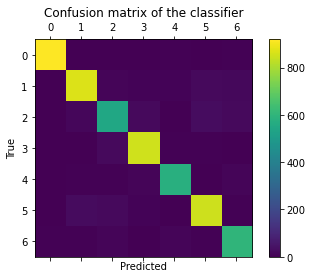

In [106]:
# SGD on TF-IDF 
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='epsilon_insensitive', epsilon=0.6, max_iter = 100)

sgd_tfidf_predictions = train_predict_model(classifier=sgd, 
                                                train_features=tv_train_features, train_labels=label_train,
                                                test_features=tv_test_features, test_labels=label_test)

display_model_performance_metrics(true_labels=label_test, predicted_labels=sgd_tfidf_predictions,
                                      classes=[0,1,2,3,4,5,6])

fetch_scores(classifier_name = 'Stochastic Gradient Descent', true_labels=label_test, 
                                     predicted_labels=sgd_tfidf_predictions)

    
# cross_validate_model(classifier=sgd, text=tv.fit_transform(text), label=label, k=10)

# stratified_cross_validate_model(classifier=sgd, text=tv.fit_transform(text), label=label, k=10)

# Finding Best Model

### Iterative SGD Model

In [107]:
from sklearn.linear_model import SGDClassifier

best_acc = 0.0
best_model = SGDClassifier(loss='epsilon_insensitive', epsilon=0.6)
acc = 0
iter = 0
max_iter = 1000

while best_acc <= 0.94 and iter <= max_iter:
    model = SGDClassifier(loss='epsilon_insensitive', epsilon=0.6)
    model.fit(tv_train_features, label_train)
    predicted_labels = model.predict(tv_test_features) 
    acc =  max(acc, metrics.accuracy_score(label_test, predicted_labels))
    if best_acc < acc: 
        best_acc = acc
        best_model = model
    iter += 1
    # print(np.round(acc, 4), np.round(best_acc, 4))
    # print(metrics.accuracy_score(label_test, predicted_labels))
    # print()
    
print('Best Accuracy:', np.round(best_acc, 4))
fetch_scores(classifier_name = 'Stochastic Gradient Descent (Iterative)', true_labels=label_test, 
                                     predicted_labels=best_model.predict(tv_test_features))

Best Accuracy: 0.9327


In [108]:
metrics.accuracy_score(label_train, model.predict(tv_train_features))

0.9991071428571429

# All Model Report

In [109]:
print(scores)

defaultdict(<function <lambda> at 0x00000185773AB5E0>, {'Stochastic Gradient Descent': [0.9314, 0.9313, 0.9314, 0.9313], 'Stochastic Gradient Descent (Iterative)': [0.9327, 0.9325, 0.9327, 0.9326]})


In [110]:
mp = {0: 'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1 Score'}
best_accuracy, best_precision, best_recall, best_f1score = 0.0, 0.0, 0.0, 0.0
for model, parameters in scores.items():
    print(model)
    print('-'*33)
    i = 0
    for p in parameters:
        best_accuracy = max(best_accuracy, parameters[0])
        best_precision = max(best_precision, parameters[1])
        best_recall = max(best_recall, parameters[2])
        best_f1score = max(best_f1score, parameters[3])
        print(' ', mp[i] + (' ' * (20-len(mp[i]))), p)
        i = i+1
    print('')

Stochastic Gradient Descent
---------------------------------
  Accuracy             0.9314
  Precision            0.9313
  Recall               0.9314
  F1 Score             0.9313

Stochastic Gradient Descent (Iterative)
---------------------------------
  Accuracy             0.9327
  Precision            0.9325
  Recall               0.9327
  F1 Score             0.9326



In [111]:
best_accuracy_models, best_precision_models, best_recall_models, best_f1score_models = [], [], [], []
for model, parameters in scores.items():
    i = 0
    for p in parameters:
        if parameters[0] is best_accuracy: best_accuracy_models.append(model)
        if parameters[1] is best_precision: best_precision_models.append(model)
        if parameters[2] is best_recall: best_recall_models.append(model)
        if parameters[3] is best_f1score: best_f1score_models.append(model)
        i = i+1

print('Best Accuracy:', best_accuracy, '\nModels:', set(best_accuracy_models))
print('\nBest Precision:', best_precision, '\nModels:', set(best_precision_models))
print('\nBest Recall:', best_accuracy, '\nModels:', set(best_recall_models))
print('\nBest F1 Score:', best_f1score, '\nModels:', set(best_f1score_models))

Best Accuracy: 0.9327 
Models: {'Stochastic Gradient Descent (Iterative)'}

Best Precision: 0.9325 
Models: {'Stochastic Gradient Descent (Iterative)'}

Best Recall: 0.9327 
Models: {'Stochastic Gradient Descent (Iterative)'}

Best F1 Score: 0.9326 
Models: {'Stochastic Gradient Descent (Iterative)'}


# User Prediction Section

In [112]:
hash_mp = {0:'CL', 1:'CR', 2:'DC', 3:'DS', 4:'LO', 5:'NI', 6:'SE'}
def user_predict(abstract, model):
    processed_abstract = re.sub('[^a-zA-Z]', ' ', abstract)
    processed_abstract = processed_abstract.lower()
    processed_abstract = word_tokenize(processed_abstract)
    ps = PorterStemmer()
    lemma = WordNetLemmatizer()
    all_stopwords = stopwords.words('english')
    processed_abstract = [lemma.lemmatize(word) for word in processed_abstract if not word in set(all_stopwords)]
    processed_abstract = [ps.stem(word) for word in processed_abstract if not word in set(all_stopwords)]
    processed_abstract = ' '.join(processed_abstract)
    category = model.predict(tv.transform([processed_abstract]))
    # print(hash_mp[category[0]])
    return hash_mp[category[0]]

In [113]:
model = best_model# Chose a model
abstract = train_df['text'][0]# String
print(user_predict(abstract, model))

LO


In [114]:
# 4 5 3 5 0

# Save File

In [115]:
df_results_sgd = pd.DataFrame(list(zip(text_test.to_list(), label_test.tolist(),sgd_tfidf_predictions.tolist())),
                          columns = ['text','true_labels','pred_labels'])
df_results_sgd.to_csv('df_results_sgd.csv')

In [52]:
df_results_sgd.head(5)

,text,true_labels,pred_labels
0,show np complet existenti theori term algebra ...,4,4
1,rapid advanc sens network comput technolog rec...,5,5
2,problem oblivi ram oram tradit studi singl ser...,1,1
3,secur multi parti comput wide studi area compu...,1,1
4,paper first present analyt discuss energi effi...,5,5
